In [1]:
# TF Agents

# Packages: pip install tf-nightly tf-agents-nightly pillow matplotlib gym

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import PIL
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.dqn import q_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import gym_wrapper
from tf_agents.environments import tf_py_environment
from tf_agents.environments import trajectory
from tf_agents.metrics import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

from PIL import Image

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display

# Hyperparameters 
num_iterations = 5000
initial_collect_steps = 1000
collect_steps_per_iteration = 1 
replay_buffer_capacity = 100000
fc_layer_params = (100,)
batch_size = 64
learning_rate = 1e-3
log_interval = 200  
num_eval_episodes = 10
eval_interval = 1000

# !!!!!!!!!!!!!!!!!!
tf.compat.v1.enable_v2_behavior()

In [2]:
# Functions

def create_gif(env):
    gif = []
    for i in range(200):
        gif.append(PIL.Image.fromarray(env.render(mode='rgb_array')))
        env.step(env.action_space.sample())

    filename = str(time.time()) +'.gif'
    print(filename)
    gif[0].save(filename, format='GIF', append_images=gif[1:], save_all=True, duration=90, loop=0)
    display(Image(url=filename))

    time.sleep(0.1) # To display the file BEFORE it removes it
    os.remove(filename)
    
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  replay_buffer.add_batch(traj) # Add trajectory to the replay buffer

In [3]:
# ENV init 
tf_env = suite_gym.load('CartPole-v0')
tf_env.reset()

train_env = tf_py_environment.TFPyEnvironment(tf_env)
eval_env = tf_py_environment.TFPyEnvironment(tf_env)

create_gif(tf_env)

1554715686.4494634.gif


In [4]:
# Agent (DQN)
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [5]:
# Policy
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)


W0405 11:10:31.347745 140453646894912 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0405 11:10:31.355251 140453646894912 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0405 11:10:31.362432 140453646894912 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0405 11:10:31.371007 140453646894912 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0405 11:10:31.377259 140453646894912 backprop.py:818] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64


step = 200: loss = 13.24293327331543
step = 400: loss = 28.239105224609375
step = 600: loss = 45.36333465576172
step = 800: loss = 28.141746520996094
step = 1000: loss = 41.08706283569336
step = 1000: Average Return = 23.700000762939453
step = 1200: loss = 32.47084045410156
step = 1400: loss = 22.452899932861328
step = 1600: loss = 29.250328063964844
step = 1800: loss = 20.4435977935791
step = 2000: loss = 34.661781311035156
step = 2000: Average Return = 66.30000305175781
step = 2200: loss = 59.59206008911133
step = 2400: loss = 75.27734375
step = 2600: loss = 54.35028076171875
step = 2800: loss = 73.85121154785156
step = 3000: loss = 52.80146026611328
step = 3000: Average Return = 77.69999694824219
step = 3200: loss = 126.77091979980469
step = 3400: loss = 19.332561492919922
step = 3600: loss = 96.30709838867188
step = 3800: loss = 105.86681365966797
step = 4000: loss = 82.61153411865234
step = 4000: Average Return = 58.0
step = 4200: loss = 112.8319091796875
step = 4400: loss = 106.6

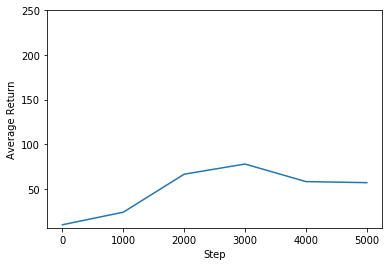

In [6]:
# Training

tf_agent.train = common.function(tf_agent.train) # (Optional) Optimize by wrapping some of the code in a graph using TF function.

tf_agent.train_step_counter.assign(0) # Reset the train step

avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes) # Evaluate the agent's policy once before training.
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, tf_agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience)

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

In [ ]:
# Evaluation

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

create_gif(tf_env)

In [ ]:
# Export